In [1]:
import numpy as np
from numpy import genfromtxt

import csv
import os

import deepSI
from deepSI import System_data

import pysindy as ps
from pysindy import SINDy

from torch import nn
import torch

import matplotlib.pyplot as plt

from scipy.io import loadmat

from deepSI.utils import simple_res_net, feed_forward_nn

from utils import SINDy_model

c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data dir and file
save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data"

out = loadmat(os.path.join(save_dir,'Silverbox_full_state_low_error.mat'))
x_data = out['xOptTot']

save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data"
out = loadmat(os.path.join(save_dir,'Silverbox_u_upsampled.mat'))
u = out['u']

dt = 1

idx_train = 800000

# trim since batchting not implemented
x_train = x_data[idx_train:,:]
u_train = u[idx_train:,:]

x_train = np.c_[x_train, u_train]

# test
x_test = x_data[0:idx_train,:]
u_test = u[0:idx_train,:]

x_test = np.c_[x_test, u_test]

def normalize(y):
  y_mu = np.mean(y)
  y_std = np.std(y)
  y_norm = (y-y_mu)/y_std

  return y_norm, y_std, y_mu

#generate function set
x_train, x_std, x_mu = normalize(x_train)

degree = 3

feature_library=ps.PolynomialLibrary(degree=degree)

# train
train_x = x_train[:-1,:]
Theta = torch.as_tensor(np.array(feature_library.fit(train_x).transform(train_x))).to(torch.float32)

if u_train is not None:
  target_x = torch.as_tensor(x_train[1:,:-1]).to(torch.float32)
else:
  target_x = torch.as_tensor(x_train[1:,:]).to(torch.float32)

# test
test_x = x_test[:-1,:]
Theta_test = torch.as_tensor(np.array(feature_library.fit(test_x).transform(test_x))).to(torch.float32)
if u_test is not None:
  target_x_test = torch.as_tensor(x_test[1:,:-1]).to(torch.float32)
else:  
  target_x_test = torch.as_tensor(x_test[1:,:]).to(torch.float32)

class MLP(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super(MLP, self).__init__()
        
        self.layer = nn.Linear(n_in, n_out, bias=False)

    def forward(self, x):
        out = self.layer(x)
        return out
    
n_in = Theta.shape[-1]
n_out = target_x.shape[-1]

In [3]:
model = MLP(n_in, n_out)
model.load_state_dict(torch.load("test"))

<All keys matched successfully>

In [4]:
threshold = 0
params = [x.detach().numpy() for x in model.parameters()][0]

NN_p_1 = params[0, np.abs(params[0,:]) > threshold]
NN_p_2 = params[1, np.abs(params[1,:]) > threshold]
NN_p = [NN_p_1, NN_p_2]

In [5]:
s_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0),
    feature_library=feature_library,
    discrete_time=True
)

s_model.fit(x_data, u=u, t=dt)

s_model.print(precision=6)

(x0)[k+1] = 1.000000 x0[k] + 1.000000 x1[k]
(x1)[k+1] = -0.000009 1 + -0.001240 x0[k] + 0.995270 x1[k] + 0.001251 u0[k] + -0.004751 x0[k]^3


In [6]:
coeff = s_model.coefficients()

S_p_1 = coeff[0, np.abs(coeff[0,:]) > threshold]
S_p_2 = coeff[1, np.abs(coeff[1,:]) > threshold]
S_p = [S_p_1, S_p_2]

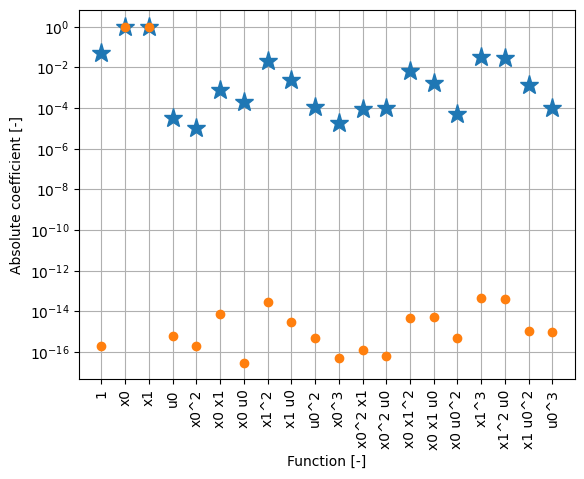

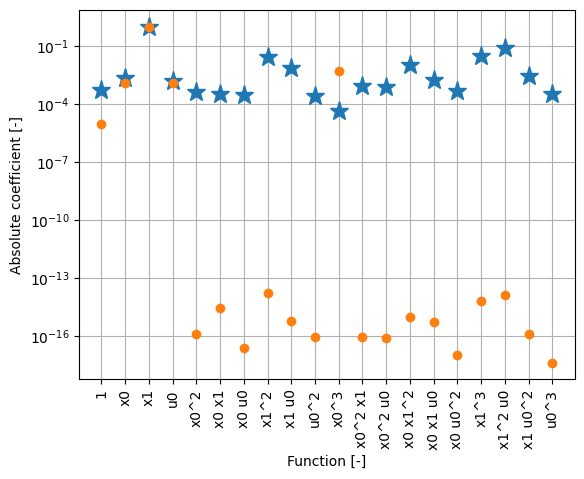

In [7]:
plt.semilogy(np.abs(NN_p[0]),"*", markersize=14)
plt.semilogy(np.abs(S_p[0]),"o")
plt.xticks(np.arange(NN_p[0].shape[0]), s_model.get_feature_names(), rotation=90)
plt.xlabel("Function [-]")
plt.ylabel("Absolute coefficient [-]")
plt.grid()
plt.show()

plt.semilogy(np.abs(NN_p[1]),"*", markersize=14)
plt.semilogy(np.abs(S_p[1]),"o")
plt.xticks(np.arange(NN_p[0].shape[0]), s_model.get_feature_names(), rotation=90)
plt.xlabel("Function [-]")
plt.ylabel("Absolute coefficient [-]")
plt.grid()
plt.show()